<a href="https://colab.research.google.com/github/thelastgreykoala/time_series/blob/main/TS_DZ2_NonStationary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Нестационарный ряд

In [8]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv", parse_dates = True)
airlines_passengers.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60':'Count'}, inplace=True)
airlines_passengers.drop([airlines_passengers.index[len(airlines_passengers)-1]], inplace=True)

In [9]:
airlines_passengers

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
138,1960-07,622
139,1960-08,606
140,1960-09,508
141,1960-10,461


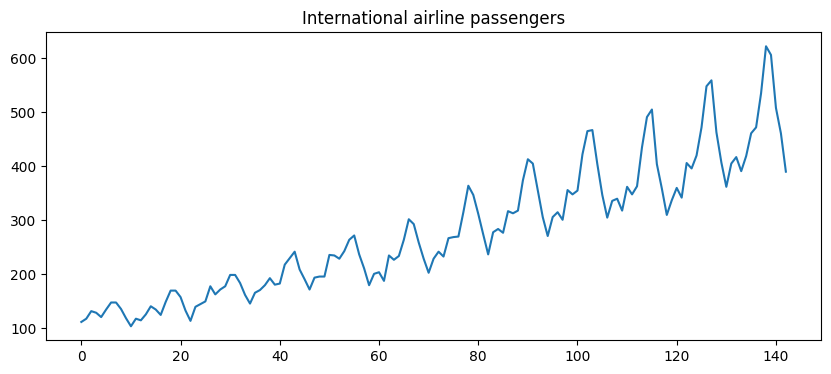

In [11]:
plt.figure(figsize=(10, 4))

plt.plot(airlines_passengers['Count'])
plt.title('International airline passengers')
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(airlines_passengers['Count'])

print('p-value = ' + str(adf_test[1]))

p-value = 0.9925254163586111


Вероятность (p-value) для данных существенно выше 0,05. Мы не можем отвергнуть нулевую гипотезу. Процесс нестанионарный.

Moving Average

In [14]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

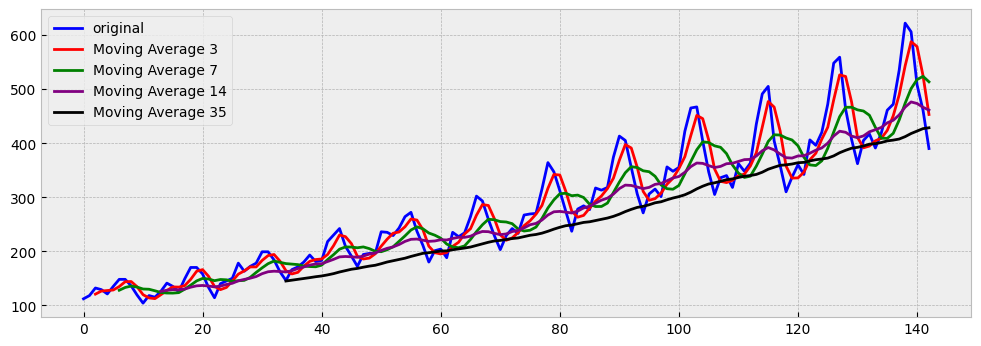

In [15]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(airlines_passengers["Count"], windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

In [16]:
def predict_ma(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        #new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
        new_series = pd.concat([new_series, pd.Series([new_series[-N:].mean()])], ignore_index=True)
    return new_series

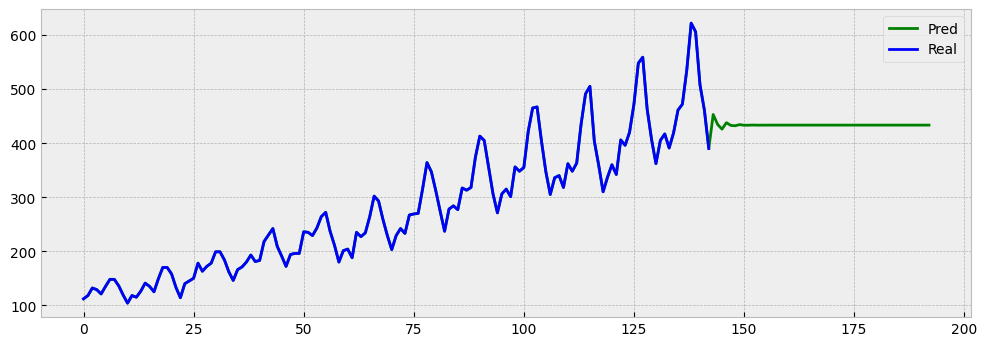

In [17]:
series_pred = predict_ma(airlines_passengers["Count"], 3, 50)
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(series_pred, color='green', linewidth='2', label='Pred')
    plt.plot(airlines_passengers["Count"], color='blue', linewidth='2', label='Real')
    plt.legend()

In [18]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [20]:
series = airlines_passengers["Count"]
len(series)

143

In [21]:
train, test = series[:114], series[114:]

In [22]:
def mse_ma(n):
    result = predict_ma(train, n, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [23]:
for i in range(1,15):
  print(f'Window = {i}, MSE = {mse_ma(i)}')

Window = 1, MSE = 6240.517241379311
Window = 2, MSE = 7203.41295246523
Window = 3, MSE = 8406.982545188193
Window = 4, MSE = 9217.104049102716
Window = 5, MSE = 10175.670825144241
Window = 6, MSE = 10948.785357351811
Window = 7, MSE = 11549.445104548346
Window = 8, MSE = 12236.643994736207
Window = 9, MSE = 12727.193034596878
Window = 10, MSE = 12885.978946948117
Window = 11, MSE = 12645.481694620263
Window = 12, MSE = 12138.310602279586
Window = 13, MSE = 11640.956169316432
Window = 14, MSE = 11394.451112996165


In [62]:
print(f'MSE MA min = {mse_ma(3)}')

MSE MA min = 8406.982545188193


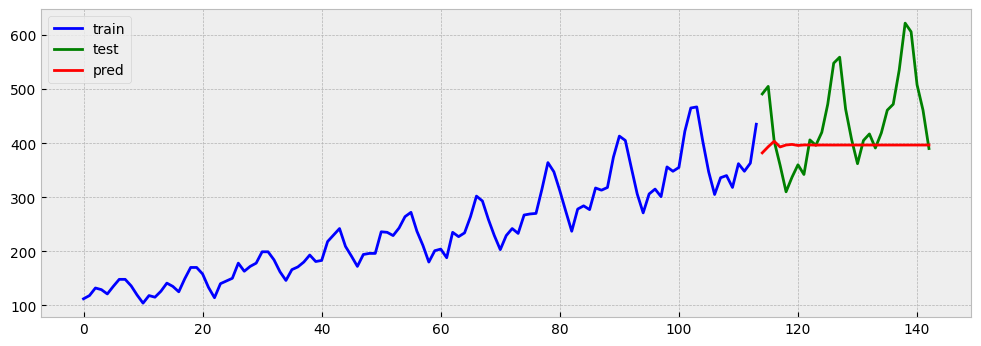

In [24]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')

    result = predict_ma(train, 3, len(test))
    predictions = result[-len(test):]
    plt.plot(predictions, color='red',label='pred')
    plt.legend()

Exponential Moving Average

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

In [25]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

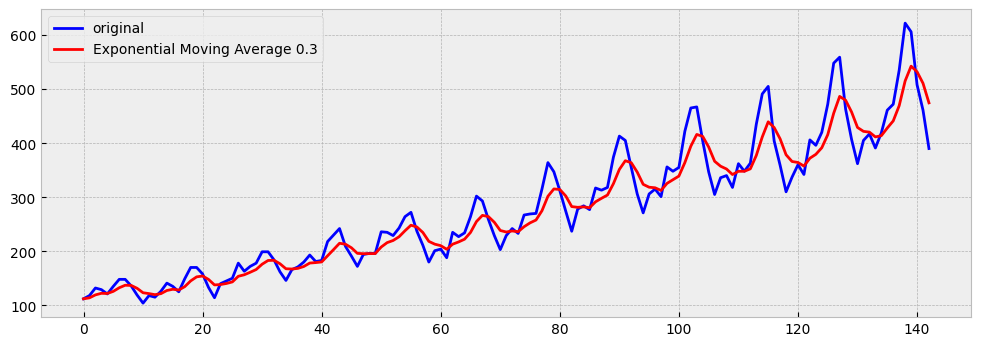

In [26]:
alpha = 0.3

with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    ser = exponential_moving_average(airlines_passengers["Count"], alpha)
    plt.plot(ser, color='red', linewidth='2', label='Exponential Moving Average {}'.format(alpha))
    plt.legend()

In [27]:
def exponential_moving_average_pred(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return pd.concat([series, pd.Series(predictions)], ignore_index=True), pd.Series(result)

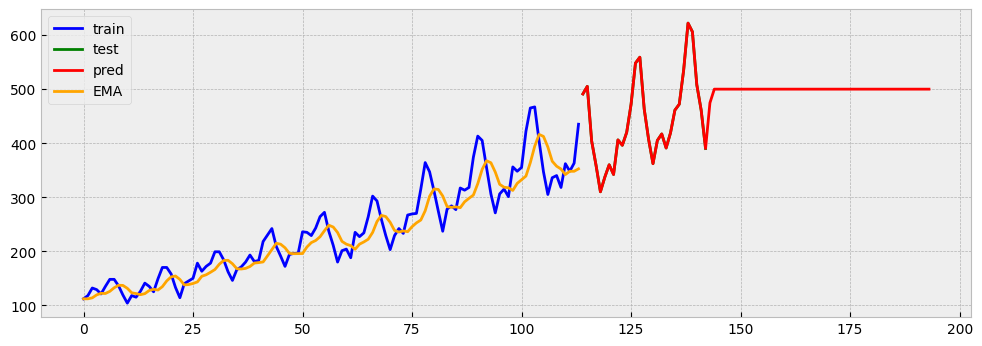

In [29]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')

    ser, res = exponential_moving_average_pred(series, 0.3, 50)
    plt.plot(ser[114:], color='red',label='pred')
    plt.plot(res[:114], color='orange',label='EMA')
    plt.legend()

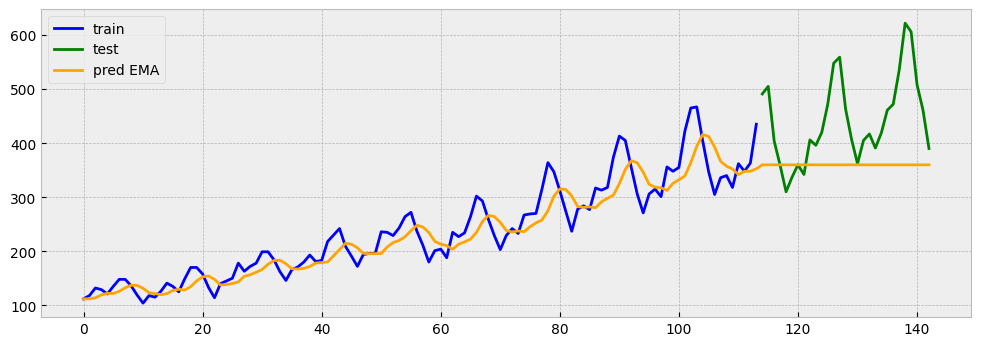

In [30]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')

    ser, res = exponential_moving_average_pred(train, 0.3, len(test))
    plt.plot(res, color='orange',label='pred EMA')
    plt.legend()

In [31]:
def mse_ema(alpha):
    ser, res = exponential_moving_average_pred(train, alpha, len(test))
    predictions = res[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [32]:
for i in np.arange(0.1, 1, 0.1):
  print(f'Alpha = {i}, MSE = {mse_ema(i)}')

Alpha = 0.1, MSE = 14339.307548367824
Alpha = 0.2, MSE = 13443.249035481915
Alpha = 0.30000000000000004, MSE = 12985.051716935148
Alpha = 0.4, MSE = 11989.301613435413
Alpha = 0.5, MSE = 10732.181474445144
Alpha = 0.6, MSE = 9470.32384888488
Alpha = 0.7000000000000001, MSE = 8324.851493048103
Alpha = 0.8, MSE = 7360.194566785823
Alpha = 0.9, MSE = 6639.8851867962985


In [73]:
opt = minimize(mse_ema, x0=0)
opt.x

array([1.05031026])

In [76]:
print(f'MSE EMA min = {mse_ema(1)}')

MSE EMA min = 6240.517241379311


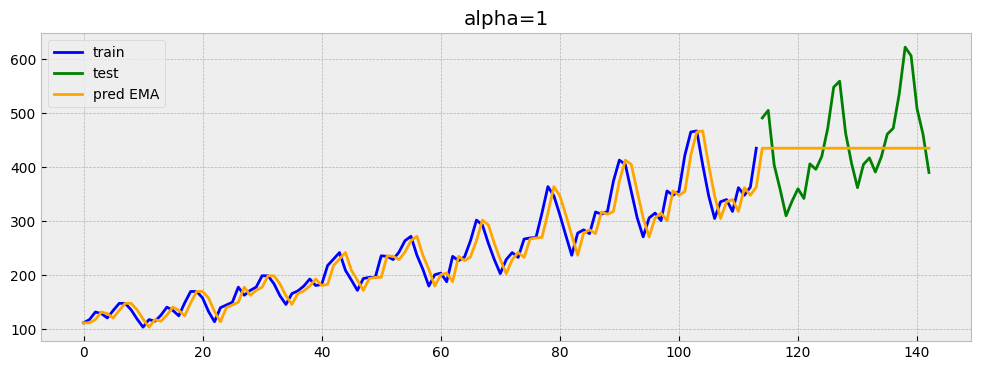

In [75]:
alpha = 1
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')

    ser, res = exponential_moving_average_pred(train, alpha, len(test))
    plt.plot(res, color='orange',label='pred EMA')
    plt.title("alpha={}".format(alpha))
    plt.legend()

Двойное экспоненциальное сглаживание

$$\hat{y}_t=l_t + s_t$$

$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$

$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$

In [35]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

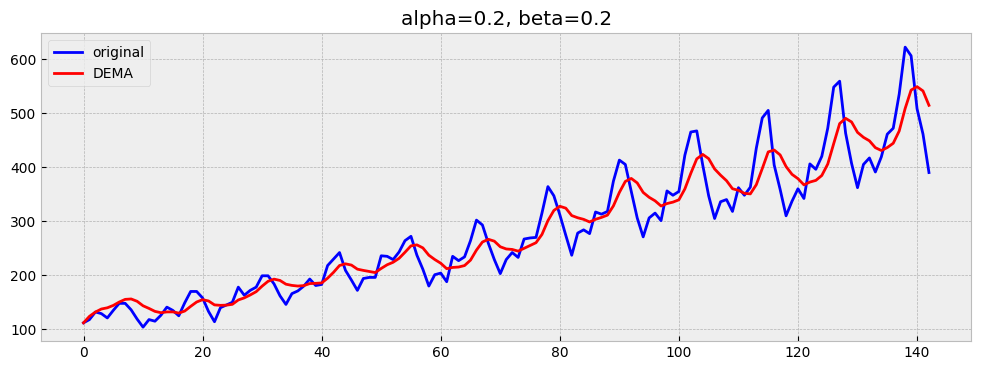

In [36]:
alpha, beta = 0.2, 0.2
dema = double_ema(airlines_passengers["Count"], alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.plot(dema, color='red', linewidth='2', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

In [37]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.concat([series, pd.Series(preds)], ignore_index=True), pd.Series(result)

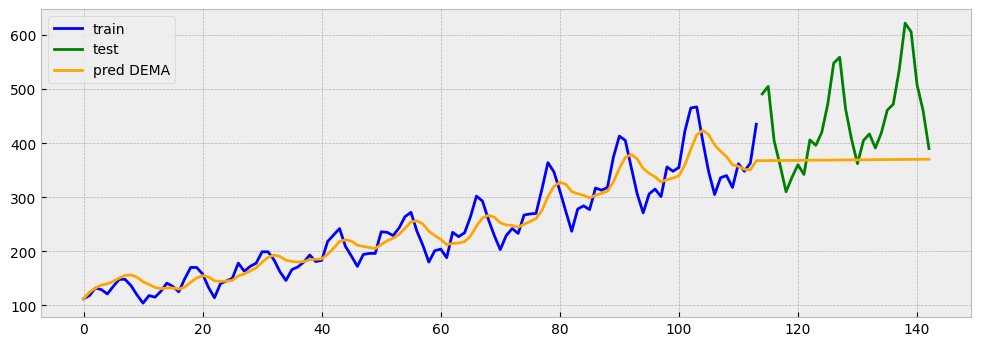

In [38]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')

    ser, res = double_ema_with_preds(train, 0.2, 0.2, len(test))
    plt.plot(res, color='orange',label='pred DEMA')
    plt.legend()

In [77]:
def mse_dema(X):
    alpha, beta = X
    ser, res = double_ema_with_preds(train, alpha, beta, len(test))
    predictions = res[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [78]:
opt = minimize(mse_dema, x0=[0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
opt.x[0], opt.x[1]

(0.38451852890617705, 0.16644605849459776)

In [81]:
print(f'MSE DEMA min = {mse_dema(opt.x)}')

MSE DEMA min = 5119.448683544344


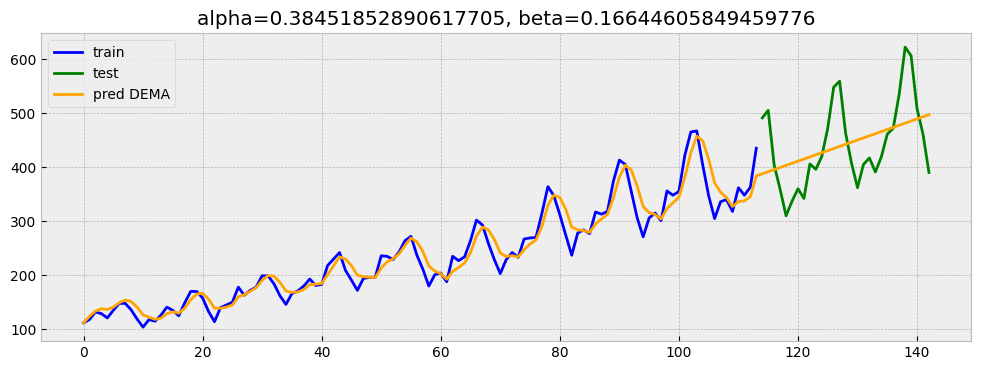

In [42]:
alpha = opt.x[0]
beta = opt.x[1]
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')

    ser, res = double_ema_with_preds(train, alpha, beta, len(test))
    plt.plot(res, color='orange',label='pred DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()



---



Хольт-Винтерс

Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

In [43]:
def initial_trend(series, season_len):
  sum = 0.0
  for i in range(season_len):
    sum += float(series[i+season_len] - series[i]) / season_len
  return sum / season_len
#    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [44]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [45]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

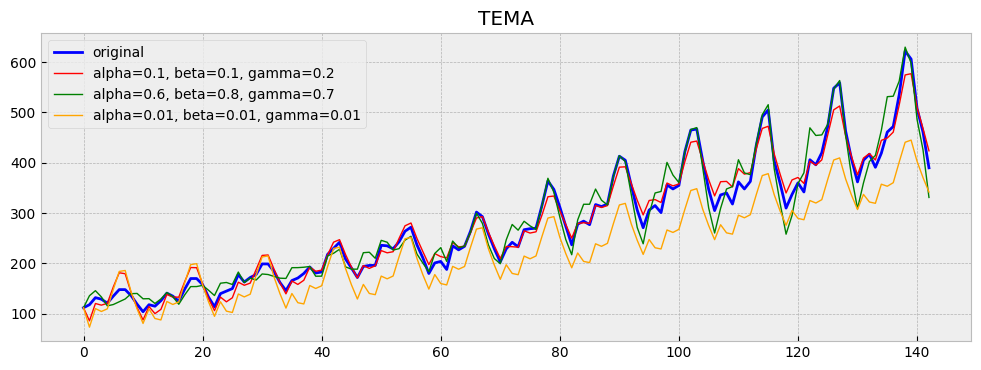

In [46]:

with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')

    alpha, beta, gamma = 0.1, 0.1, 0.2
    tema = triple_exponential_smoothing(airlines_passengers["Count"], 12, alpha, beta, gamma, 0)
    plt.plot(tema, color='red', linewidth='1', label="alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))

    alpha, beta, gamma = 0.6, 0.8, 0.7
    tema = triple_exponential_smoothing(airlines_passengers["Count"], 12, alpha, beta, gamma, 0)
    plt.plot(tema, color='green', linewidth='1', label="alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))

    alpha, beta, gamma = 0.01, 0.01, 0.01
    tema = triple_exponential_smoothing(airlines_passengers["Count"], 12, alpha, beta, gamma, 0)
    plt.plot(tema, color='orange', linewidth='1', label="alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))

    plt.title("TEMA")
    plt.legend()

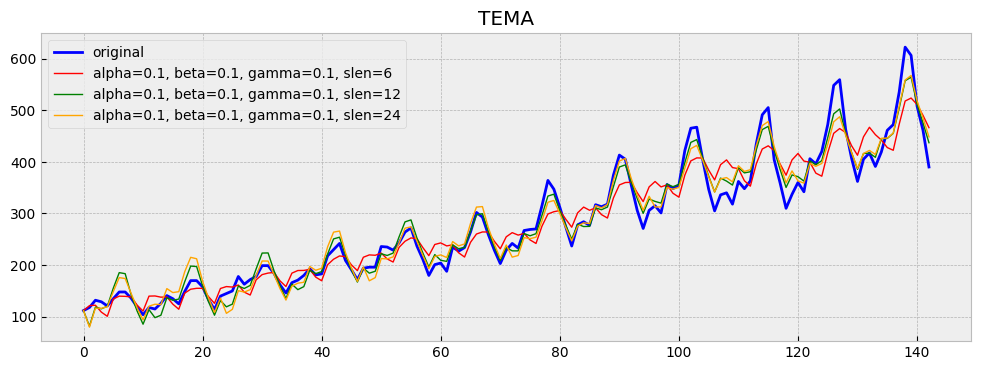

In [50]:

with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')

    alpha, beta, gamma = 0.1, 0.1, 0.1
    slen = 6
    tema = triple_exponential_smoothing(airlines_passengers["Count"], slen, alpha, beta, gamma, 0)
    plt.plot(tema, color='red', linewidth='1', label="alpha={}, beta={}, gamma={}, slen={}".format(alpha, beta, gamma, slen))

    slen = 12
    tema = triple_exponential_smoothing(airlines_passengers["Count"], slen, alpha, beta, gamma, 0)
    plt.plot(tema, color='green', linewidth='1', label="alpha={}, beta={}, gamma={}, slen={}".format(alpha, beta, gamma, slen))

    slen = 24
    tema = triple_exponential_smoothing(airlines_passengers["Count"], slen, alpha, beta, gamma, 0)
    plt.plot(tema, color='orange', linewidth='1', label="alpha={}, beta={}, gamma={}, slen={}".format(alpha, beta, gamma, slen))

    plt.title("TEMA")
    plt.legend()

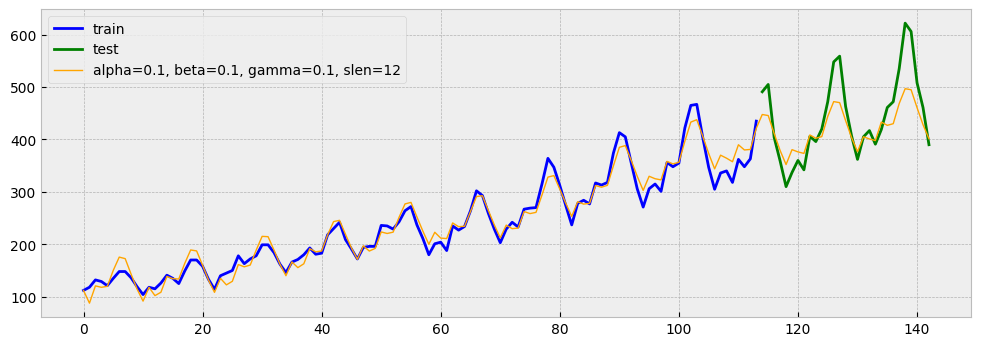

In [51]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')

    # ser, res = double_ema_with_preds(train, 0.2, 0.2, len(test))
    # plt.plot(res, color='orange',label='pred DEMA')

    alpha, beta, gamma = 0.1, 0.1, 0.1
    slen = 12
    tema = triple_exponential_smoothing(train, slen, alpha, beta, gamma, len(test))
    plt.plot(tema, color='orange', linewidth='1', label="alpha={}, beta={}, gamma={}, slen={}".format(alpha, beta, gamma, slen))

    plt.legend()

In [82]:
def mse_tema(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [83]:
opt = minimize(mse_tema, x0=[0, 0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
opt.x

array([1.        , 0.01183529, 1.        ])

In [85]:
print(f'MSE TEMA min = {mse_tema(opt.x)}')

MSE TEMA min = 2002.3581527785595


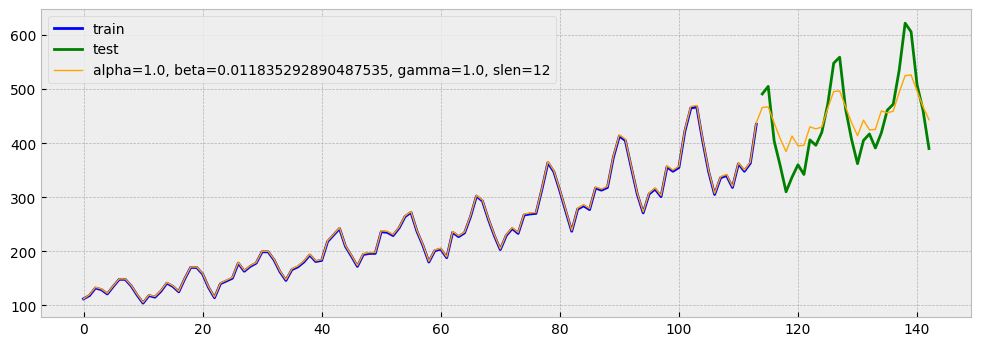

In [58]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')

    alpha, beta, gamma = opt.x
    slen = 12
    tema = triple_exponential_smoothing(train, slen, alpha, beta, gamma, len(test))
    plt.plot(tema, color='orange', linewidth='1', label="alpha={}, beta={}, gamma={}, slen={}".format(alpha, beta, gamma, slen))

    plt.legend()

Нестационарный ряд лучше всего аппроксимируется TEMA, так как у него есть и сезонность, и тренд. MSE получилась порядка 2000, по остальным моделям гораздо больше.